In [1]:
#|default_exp conv

Code from miniai.training

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Code from miniai.datasets

In [3]:
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

## Convolutions

In [4]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

In [5]:
import pickle,gzip,math,os,time,shutil,matplotlib as mpl,numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [6]:
mpl.rcParams['image.cmap'] = 'gray'

In [7]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [8]:
with gzip.open(path_gz, 'rb') as f: ((x_trn, y_trn), (x_val, y_val), _) = pickle.load(f, encoding='latin-1')

In [9]:
x_trn, y_trn, x_val, y_val = map(tensor, [x_trn, y_trn, x_val, y_val])

### Understanding the Convolution Equations

In [10]:
x_imgs = x_trn.view(-1,28,28)
xv_imgs = x_val.view(-1,28,28)

In [11]:
mpl.rcParams['figure.dpi'] = 50

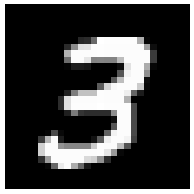

In [12]:
im3 = x_imgs[7]
show_image(im3);

In [13]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

<Axes: >

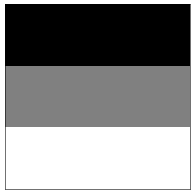

In [14]:
show_image(top_edge, noframe=False)

In [15]:
df = pd.DataFrame(im3)
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03,0.00,0.00,0.00,0.00,0.00


In [16]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [17]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [18]:
def apply_kernel(row,col,kernel): return (im3[row-1:row+2,col-1:col+2]*kernel).sum()

In [19]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

In [20]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

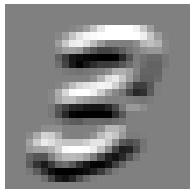

In [21]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

In [22]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

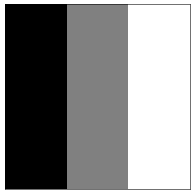

In [23]:
show_image(left_edge, noframe=False);

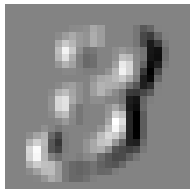

In [24]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

### Convolutions in PyTorch

In [25]:
import torch.nn.functional as F
import torch

In [26]:
inp = im3[None,None,:,:].float()
print(inp.shape)

inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([1, 1, 28, 28])


torch.Size([9, 676])

Is `676 = (28-2) x (28-2)`? I.e., the number of slides?

In [27]:
26*26

676

Yup.

In [28]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [29]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

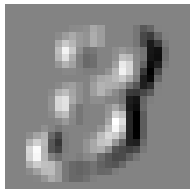

In [30]:
out = out_unf.view(26,26)
show_image(out);

In [31]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge)  for j in rng] for i in rng]);

10.9 ms ± 528 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

50.5 µs ± 3.47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 5.61 times longer than the fastest. This could mean that an intermediate result is being cached.
34.1 µs ± 33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
diag1_edge = tensor([[0,-1,1],
                     [-1,1,0],
                     [1,0,0]]).float()

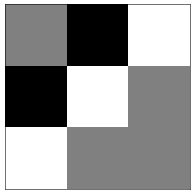

In [35]:
show_image(diag1_edge, noframe=False);

In [36]:
diag2_edge = tensor([[1,-1,0],
                     [0,1,-1],
                     [0,0,1]]).float()

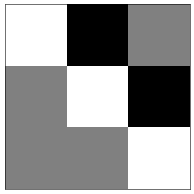

In [37]:
show_image(diag2_edge, noframe=False);

In [38]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [39]:
x_imgs[:16].unsqueeze(1).shape

torch.Size([16, 1, 28, 28])

In [40]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [41]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

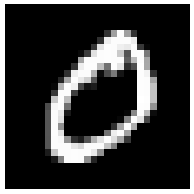

In [42]:
img0 = xb[1,0]
show_image(img0);

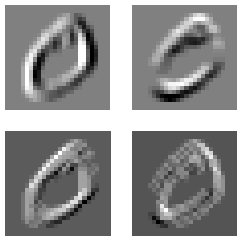

In [43]:
show_images([batch_features[1,i] for i in range(4)])

## Creating the CNN

In [44]:
n,m = x_trn.shape
c = y_trn.max()+1 # should be 10
nh=50
n,m,c,nh

(50000, 784, tensor(10), 50)

In [45]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [46]:
model(xb.flatten(1)).shape

torch.Size([16, 10])

In [47]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [48]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

Note Umer: This is 'broken', as its output is not of shape `(bs=16,10)`.<br/>
To fix it, we need to add a stride.

In [49]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring parts of your neural network like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

Note Umer: Above, we have
- automated the computation of `padding`
- fixed the parts that don't change (`kernel_size`, `stride`)
- and simplified calling activation (`relu`)

In [50]:
simple_cnn = nn.Sequential(
    conv(1, 4),  # 14x14
    conv(4, 8),  # 7x7
    conv(8, 16), # 4x4
    conv(16,16), # 2x2
    conv(16,10, act=False), #1x1
    nn.Flatten()
)

In [51]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [52]:
x_imgs = x_trn.view(-1,1,28,28)
xv_imgs= x_val.view(-1,1,28,28)
trn_ds,val_ds = Dataset(x_imgs,y_trn), Dataset(xv_imgs,y_val)

In [53]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x,device=def_device):
    if isinstance(x,torch.Tensor): return x.to(device)
    if isinstance(x,Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o,device) for o in x)

def collate_device(b): return to_device(default_collate(b))

**Q:** In `to_device` above, if x is a np.array (e.g. np.array(range(10)), are we sending each item separately to the gpu? <br/>
If yes, is the reasond we don't care that we don't use numpy, but only use torch?

In [54]:
from torch import optim

bs = 256
lr = 0.4
trn_dl,val_dl = get_dls(trn_ds,val_ds,bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [55]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, trn_dl, val_dl)

0 0.5888300724983215 0.8121000003814697
1 0.16764804756641388 0.9484000007629394
2 0.1339406509399414 0.9613000007629394
3 0.13637050297260284 0.960400000667572
4 0.13602256319522857 0.9582000001907348


We reduce the learning rate and train further

In [56]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,arc = fit(5, simple_cnn, F.cross_entropy, opt, trn_dl, val_dl)

0 0.08484998407363892 0.9747999992370605
1 0.08640038630962373 0.9747999995231629
2 0.08384894771575928 0.9744999992370605
3 0.09273242268562316 0.972500000667572
4 0.08120379865169525 0.975299999332428


## Understanding Convolutional Arithmetic

In an input of size `64x1x28x28` the axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.

We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [57]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [58]:
simple_cnn[0]

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [59]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [60]:
conv1.bias.shape

torch.Size([4])

### Color images

In [61]:
from torchvision.io import read_image

In [62]:
!pip install -Uqq fastdownload

In [63]:
from fastdownload import download_url

In [64]:
bear_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/2010-kodiak-bear-1.jpg/1920px-2010-kodiak-bear-1.jpg'
download_url(bear_url, 'images/bear.jpg')

Path('images/bear.jpg')

In [65]:
im = read_image('images/bear.jpg')
im.shape

torch.Size([3, 1280, 1920])

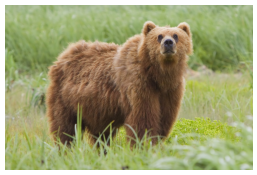

In [66]:
show_image(im.permute(1,2,0));

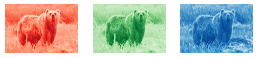

In [67]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

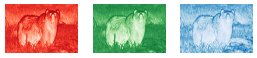

In [68]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(bear, ax=ax, cmap=color)